# Training the single-site/multi-site event classifier

This notebook shows how to train a single-site/multi-site event classifier using TensorFlow. Some knowledge of Python and neural networks is assumed. In particular, Python packages including `numpy` and `matplotlib` will be used frequently. For neural networks, a high-level understanding is assumed, although a deep understanding of the details is not strictly required.

This notebook will cover all of the basics of TensorFlow, and so no previous experience with TensorFlow (or a similar framework) is necessary nor expected.

## Configuration and imports

In [1]:
from pathlib import Path
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
# For interactive plots (https://matplotlib.org/stable/users/explain/interactive.html).
#%matplotlib notebook

In [3]:
# Default matplotlib settings for the notebook to make plots look relatively OK.
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.alpha'] = 0.5
mpl.rcParams['figure.figsize'] = (7, 4)
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

In [4]:
# For reproducibility.
np.random.seed(621959)
tf.random.set_seed(103567)

## Load the data

Here, we load in the training data that was generated via the `generate_data.py` script (make sure to run this before going through the notebooks). The data consist of simulated 1-dimensional pulses from a germanium detector. Each pulse is of length 512 samples and contains a random level of detector noise. Some of the pulses are single-site events, while others are multi-site events.

We also print out some properties of the data, such as the maximum number of sites in the dataset and the fraction of events for each site.

In [5]:
datadir = Path("data/simulations")

In [6]:
X_noisy = np.load(Path(datadir, "train", "X_noisy_library.npy"))
X_clean = np.load(Path(datadir, "train", "y_clean_library.npy"))
y_nsite = np.load(Path(datadir, "train", "y_nsite_library.npy"))

In [7]:
print(np.min(y_nsite), np.max(y_nsite))

1 5


In [8]:
number, counts = np.unique(y_nsite, return_counts=True)
for n, c in zip(number, counts):
    print(f"Number of events with {n} site(s): {c}")

Number of events with 1 site(s): 12567
Number of events with 2 site(s): 3141
Number of events with 3 site(s): 3141
Number of events with 4 site(s): 3141
Number of events with 5 site(s): 3141


In [9]:
y_nsite

array([[4],
       [1],
       [5],
       ...,
       [1],
       [4],
       [1]])

### Binarize the targets

For the sake of simplicity, we will classify single-site/multi-site events rather than try to predict the exact number of sites. Furthermore, single-site/multi-site event discrimination is still extremely useful and relevant to rare event searches such as neutrinoless double-beta decay.

To binarize the targets, we simply take single-site events to correspond to 0 (`False`), and multi-site events to correspond to 1 (`True`). This is of course arbitrary, and one could just as easily flip the categories.

In [10]:
y = (y_nsite > 1).astype(int)

In [11]:
y

array([[1],
       [0],
       [1],
       ...,
       [0],
       [1],
       [0]])

## Plot example pulses

The following figures plot an example single-site and multi-site event, respectively. The noisy pulse, which is the input to the neural network for classifying multi-site events, is shown in blue. The corresponding clean underlying pulse is shown in orange. The derivative of the pulse is also shown to emphasize the peaks.

### Example single-site event

The code below uses `np.random.choice` to get a random event from all of the single-site events (class 0).

If your file(s) contained very many events and you were evaluating this frequently, it would probably be more resource efficient to use `np.random.randint` instead :)

In [12]:
all_indexes_sse = np.arange(y.shape[0])[y[:, 0] == 0]
index_sse = np.random.choice(all_indexes_sse)

In [13]:
print(index_sse)
print(y_nsite[index_sse, 0])
print(y[index_sse, 0])

8850
1
0


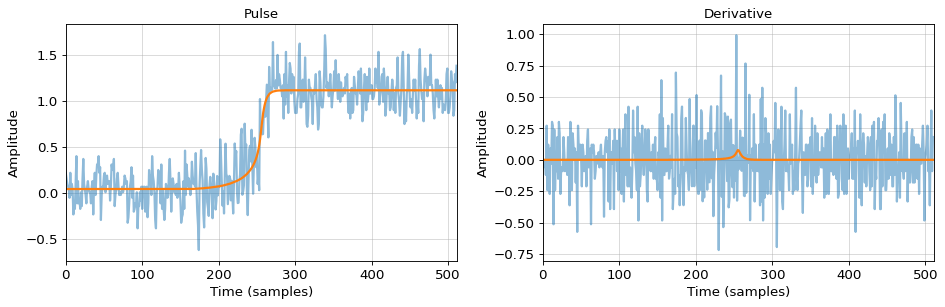

In [14]:
fig_sse, axes_sse = plt.subplots(ncols=2, figsize=(12, 4))

axes_sse[0].plot(X_noisy[index_sse], alpha=0.5)
axes_sse[0].plot(X_clean[index_sse])
axes_sse[0].set_xlim([0, X_noisy.shape[1]])

axes_sse[1].plot(np.diff(X_noisy[index_sse]), alpha=0.5)
axes_sse[1].plot(np.diff(X_clean[index_sse]))
axes_sse[1].set_xlim([0, X_noisy.shape[1]])

axes_sse[0].set_xlabel("Time (samples)")
axes_sse[1].set_xlabel("Time (samples)")

axes_sse[0].set_ylabel("Amplitude")
axes_sse[1].set_ylabel("Amplitude")

axes_sse[0].set_title("Pulse")
axes_sse[1].set_title("Derivative")

plt.tight_layout()

### Example multi-site event

The code below gets a random event from all of the multi-site events (using the same idea as above).

In [15]:
all_indexes_mse = np.arange(y.shape[0])[y[:, 0] == 1]
index_mse = np.random.choice(all_indexes_mse)

In [16]:
print(index_mse)
print(y_nsite[index_mse, 0])
print(y[index_mse, 0])

12980
5
1


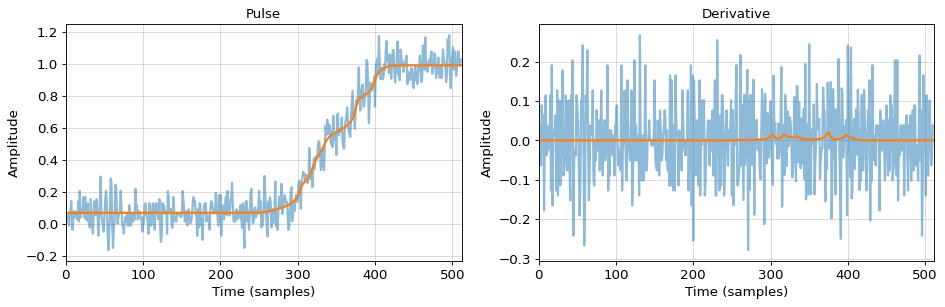

In [17]:
fig_mse, axes_mse = plt.subplots(ncols=2, figsize=(12, 4))

axes_mse[0].plot(X_noisy[index_mse], alpha=0.5)
axes_mse[0].plot(X_clean[index_mse])
axes_mse[0].set_xlim([0, X_noisy.shape[1]])

axes_mse[1].plot(np.diff(X_noisy[index_mse]), alpha=0.5)
axes_mse[1].plot(np.diff(X_clean[index_mse]))
axes_mse[1].set_xlim([0, X_noisy.shape[1]])

axes_mse[0].set_xlabel("Time (samples)")
axes_mse[1].set_xlabel("Time (samples)")

axes_mse[0].set_ylabel("Amplitude")
axes_mse[1].set_ylabel("Amplitude")

axes_mse[0].set_title("Pulse")
axes_mse[1].set_title("Derivative")

plt.tight_layout()

## TensorFlow

### Overview

From [tensorflow.org](https://www.tensorflow.org/):

```
"TensorFlow is an end-to-end open source platform for machine learning. It has a comprehensive, flexible ecosystem of tools, libraries and community resources that lets researchers push the state-of-the-art in ML and developers easily build and deploy ML powered applications."
```

That's a pretty good summary of what TensorFlow is. It was created internally at Google Brain and later open-sourced in 2015. TensorFlow makes machine learning (and particularly neural networks) extremely accessible, perhaps to a fault. It abstracts away most of the mathematics behind the scenes, which is great because the computations behind training a neural network are very tedious. However, this also means that you *technically* don't need to understand neural networks very well to use TensorFlow. Of course, this isn't a particularly good idea. As mentioned previously, this tutorial is not intended to cover the mathematics behind neural networks. If interested in learning more about that, here are some resources I recommend:

* Michael A. Nielsen. *Neural Networks and Deep Learning*: http://neuralnetworksanddeeplearning.com/
* Ian Goodfellow, Yoshua Bengio, and Aaron Courville. *Deep Learning*: https://www.deeplearningbook.org/

It should also be noted that other frameworks like TensorFlow exist. Likely the most well known competitor is [PyTorch](https://pytorch.org/). I will not try to compare and contrast these two frameworks here.

### How does TensorFlow work?

Broadly speaking, TensorFlow represents models as directed dataflow graphs. The nodes of the graph are operations. Data, which are tensors or multi-dimensional arrays, flow along the edges of the graph into and out of nodes. Thus, the edges also represent dependencies between nodes.

Representing neural networks as graphs has several advantages. It allows for models to be deployed across a wide range of devices that may not have access to a Python installation because a graph is really just an abtract representation of a computation. It is also easier to distribute nodes across multiple devices and handle the connections and communication separately. Graphs are also easily optimized. Portions of the computation that are independent can be run in parallel, for example. Read more about graphs in TensorFlow's [introduction to graphs guide](https://www.tensorflow.org/guide/intro_to_graphs). The [original 2015 whitepaper](http://download.tensorflow.org/paper/whitepaper2015.pdf) is also informative.

All of this happens under-the-hood, and so you don't need to worry too much about the details at this stage (although the details are interesting). However, if ever deploying a model in production, such implementation details could become important.

### How do we actually use TensorFlow?

We will use a high-level API in TensorFlow called [Keras](https://www.tensorflow.org/api_docs/python/tf/keras). Keras was originally a wrapper for various backends to make building neural networks more friendly. It is now contained within TensorFlow. It makes building and training neural networks user-friendly, but also has a lot of flexibility should you need it.

## Build a simple neural network

To get started, it is easiest to jump right into an example. Keras itself contains a sequential and functional API for building neural networks. Examples of constructing a model with both are shown below.

### Construct a model with the sequential API

With the [sequential API](https://www.tensorflow.org/guide/keras/sequential_model), layers are stacked together in sequence using the [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) class. As an example, we will create a model with one hidden layer. As this is a fully connected neural network, the [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) class will be used for each layer. Also note that the first layer in a sequential model must have the `input_shape` parameter specified, which should be a tuple and does *not* include the batch size. In our case, since the pulses are of length 512 samples, we need to set `input_shape=(512,)`.

As for the network, we will use one hidden layer with 128 units (arbitrarily chosen) and an output with only one unit, representing the probability that the input is a multi-site event. This is a very simple model, but good enough for our purposes. As it turns out, constructing such a model is only three lines of code with the sequential model:

In [18]:
model_dense_seq = tf.keras.models.Sequential(name="model_dense_sequential_example")

model_dense_seq.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(512,)))
model_dense_seq.add(tf.keras.layers.Dense(1, activation='sigmoid'))

That's all you really need to define a sequential model! For now, don't worry too much about the details, like the number of units in the hidden layer and the activation functions. We will come back to that. This portion of the tutorial is meant to highlight the API.

### Construct a model with the functional API

The sequential model is fine for simple models, but is very limited as layers can only be stacked one-by-one. Keras also offers a functional API to construct more complicated models. The functional API supports shared layers, multiple inputs and outputs, and non-sequential dependencies. In my opinion, it is worth learning and sticking with the functional API immediately. You will quickly encounter too many limitations with the sequential API and the functional API is not too much harder to learn.

The [functional API](https://www.tensorflow.org/guide/keras/functional) constructs neural networks as a directed graph. The graph is constructed by applying a layer's call method on the previous output. The model is then defined by specifying which layer(s) are the inputs and which layer(s) are the outputs in the constructor of the [`tf.keras.Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model) class.

It is easiest to understand this concept with an example. We will construct the same model above using the functional API. Again, we must specify the shape of the inputs, *but* we start with a specific input layer rather than specifying in argument in the first hidden layer of the network. The [`tf.keras.Input`](https://www.tensorflow.org/api_docs/python/tf/keras/Input) defines the first node of the graph.

In [19]:
input_signal = tf.keras.Input(shape=(512,))

Now, we can define layers and apply them to the previous nodes. Again, we will use the [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) class as we are constructing a simple neural network.

In [20]:
dense_layer_1 = tf.keras.layers.Dense(128, activation='relu')
hidden = dense_layer_1(input_signal)

In [21]:
dense_layer_2 = tf.keras.layers.Dense(1, activation='sigmoid')
output = dense_layer_2(hidden)

Notice how the call method `dense_layer_1` is applied to the input node, and then the call method of `dense_layer_2` is applied to the second node (corresponding to the hidden layer). The explicit naming here is done for illustrative purposes. However, there is no real reason to save the `Layer` objects themselves. It is also allowed to use the same identifier for each node, although if you want to define submodels, it would be wise to use different names. With these shortcuts, often model definitions look more like:

```python
input_signal = tf.keras.Input(shape=(512,))
x = tf.keras.layers.Dense(128, activation='relu')(input_signal)
x = tf.keras.layers.Dense(2, activation='relu')(x)
```

Now, to actually construct the model, we specify the input and output nodes to the [`tf.keras.Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model) class. As with [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential), we can also provide the `name` argument and give the model a unique name.

In [22]:
model_dense_fun = tf.keras.Model(inputs=input_signal, outputs=output, name="model_dense_functional_example")

## Visualize the simple neural network

It is useful to visualize the models and obtain properties such as the total number of parameters. There are several ways to do this. One is to use the [`summary`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary) method of the [`tf.keras.Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model) object. Below, we can see that the sequential and functional models defined in the previous section are equivalent (although the summary for the functional model includes the input layer).

In [23]:
model_dense_seq.summary(line_length=55)

Model: "model_dense_sequential_example"
_______________________________________________________
Layer (type)            Output Shape          Param #  
dense (Dense)           (None, 128)           65664    
_______________________________________________________
dense_1 (Dense)         (None, 1)             129      
Total params: 65,793
Trainable params: 65,793
Non-trainable params: 0
_______________________________________________________


In [24]:
model_dense_fun.summary(line_length=55)

Model: "model_dense_functional_example"
_______________________________________________________
Layer (type)            Output Shape          Param #  
input_1 (InputLayer)    [(None, 512)]         0        
_______________________________________________________
dense_2 (Dense)         (None, 128)           65664    
_______________________________________________________
dense_3 (Dense)         (None, 1)             129      
Total params: 65,793
Trainable params: 65,793
Non-trainable params: 0
_______________________________________________________


There are also other utilities to visualize the model, such as with the [`tf.keras.utils.plot_model`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model) function. This tool plots the model as a graph, which is particularly useful when there are non-sequential dependencies. Once again, we can see that the models defined with the two APIs are equivalent.

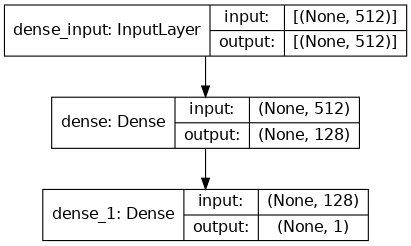

In [25]:
tf.keras.utils.plot_model(model_dense_seq, "/tmp/sequential.png", show_shapes=True, dpi=80)

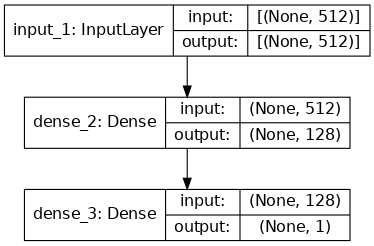

In [26]:
tf.keras.utils.plot_model(model_dense_fun, "/tmp/functional.png", show_shapes=True, dpi=80)

## Configure and train the simple neural network

In the previous sections, we have focused only on defining the neural network. However, we have not actually trained it. Each layer is initialized with random weights, and so the network is effectively useless at this point. To see this, we will use the [`tf.keras.Model.predict`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict) method on the training data to obtain the predictions.

As a quick note, from now on, we will stick to using the model constructed with the functional API. However, this choice is not particularly important and does not change how any of the training and configuration is done.

In [27]:
y_pred_dense_fun = model_dense_fun.predict(X_noisy, batch_size=512, verbose=1)

50/50 [==============================] - 0s 2ms/step


In [28]:
# Convert predictions to a binary value.
y_pred_dense_fun = (y_pred_dense_fun < 0.5).astype(int)

In [29]:
acc_dense_fun = accuracy_score(y, y_pred_dense_fun) * 100
print(f"Overall accuracy: {acc_dense_fun:.2f}%")

Overall accuracy: 50.14%


There will be more on making predictions later, but the point is that the accuracy is terrible -- no better than randomly guessing the class. This, of course, makes sense. We haven't trained the model yet!

### Compile the model

The next step is to compile the model. This is where we specify certain aspects of the training procedure, including the loss function to minimize, the optimizer to use, and any metrics we wish to evaluate during training. The [`tf.keras.Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model) class has a [`compile`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) method where all of these can be specified.

For simplicity, we will use the binary cross entropy loss ([`tf.keras.metrics.binary_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/binary_crossentropy)). As a reminder, the cross entropy loss for a binary target is defined as

$$
L = -\frac{1}{N} \sum_i^N \left( y_i \ln(a_i) + (1-y_i) \ln(1 - a_i) \right),
$$

where $N$ is the number of training samples, $y_i$ is the target (known truth value, either 0 or 1), and $a_i$ is the prediction from the neural network. I won't go into the details of this loss function, but it has motivations in information theory and maximum likelihood estimation. What I will note is that intuitively, it makes sense. If $y_i=1$ but the prediction $a_i$ is close to zero (i.e., the prediction is incorrect), the logarithm will be a large negative number, which will then become a large positive number when multiplied by the negative sign outside of the expression.

In [30]:
loss = tf.keras.metrics.binary_crossentropy

For the optimizer, we will use stochastic gradient descent. It is the most basic optimizer, but also the most intuitive. There are more advanced optimizers that typically work better, and the ones available in TensorFlow are contained in the [`tf.keras.optimizers`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) module. The stochastic gradient descent optimizer is called [`SDG`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) in TensorFlow. It accepts a number of parameters for more advanced techniques that can help the optimization process in practice, though we will just specify the (arbitrarily chosen) learning rate.

In [31]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)

The metrics we choose do not impact the training, but they can be useful for seeing how the model is doing. There are numerous metrics available in the [`tf.keras.metrics`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) module. Some of the ones relevant to our classification task include [`BinaryAccuracy`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/BinaryAccuracy), [`Precision`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), and [`Recall`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall). We will just use the accuracy, but a list of any combination of metrics can be provided.

In [32]:
metric_list = [tf.keras.metrics.BinaryAccuracy()]

Finally, we can compile the model with the [`tf.keras.Model.compile`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) method 

In [33]:
model_dense_fun.compile(loss=loss,
                        optimizer=optimizer,
                        metrics=metric_list)

### Train the model

It is now time to train the model. The [`tf.keras.Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model) class has a [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method which performs a standard training loop. This loop computes the forward pass, computes the gradients based on the loss function, and updates the weights of the neural network via backpropogation over the entire training dataset. It can accept numerous inputs, although the only required ones are the inputs and the targets. Other useful arguments include `batch_size` (the size of each minibatch), `epochs` (the number of iterations over the dataset to perform) and `shuffle` (whether or not to randomly shuffle the data).

Also note that the [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method returns a [`History`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History) object, which contains a number of useful metrics computed over the training loops. We will save and analyze this.

Finally, just before training, we will save the current (randomly initialized) weights of the model. It will become clear why this needs to be done soon.

In [34]:
dense_weights_file = "/tmp/model_dense_functional_weights.h5"
model_dense_fun.save_weights(dense_weights_file)

In [35]:
history = model_dense_fun.fit(X_noisy, y, epochs=10, verbose=1)

Epoch 1/10
786/786 [==============================] - 2s 2ms/step - loss: 0.6640 - binary_accuracy: 0.5930
Epoch 2/10
786/786 [==============================] - 2s 2ms/step - loss: 0.6265 - binary_accuracy: 0.6625
Epoch 3/10
786/786 [==============================] - 2s 2ms/step - loss: 0.5833 - binary_accuracy: 0.7290
Epoch 4/10
786/786 [==============================] - 1s 2ms/step - loss: 0.5333 - binary_accuracy: 0.7740
Epoch 5/10
786/786 [==============================] - 2s 2ms/step - loss: 0.4844 - binary_accuracy: 0.8075
Epoch 6/10
786/786 [==============================] - 2s 2ms/step - loss: 0.4421 - binary_accuracy: 0.8261
Epoch 7/10
786/786 [==============================] - 2s 2ms/step - loss: 0.4123 - binary_accuracy: 0.8366
Epoch 8/10
786/786 [==============================] - 2s 2ms/step - loss: 0.3909 - binary_accuracy: 0.8437
Epoch 9/10
786/786 [==============================] - 2s 2ms/step - loss: 0.3732 - binary_accuracy: 0.8534
Epoch 10/10
786/786 [================

Clearly, the model is starting to improve with training. Looking at the accuracy, it is improving (and fairly quickly at that) far beyond what a random guess would produce. The loss is also rapidly decreasing.

Let's now take a look at this [`History`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History) object that was returned. It has an attribute called `params` and an attribute called `history` which are of interest. The `history` attribute is a dictionary of keys corresponding to the metrics evaluted at the end of each epoch. We can plot these as a function of the number of epochs elapsed.

In [36]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 786}

In [37]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy'])

In [38]:
acc_train = np.array(history.history["binary_accuracy"]) * 100
loss_train = np.array(history.history["loss"])

epochs = np.arange(1, len(acc_train) + 1, 1)

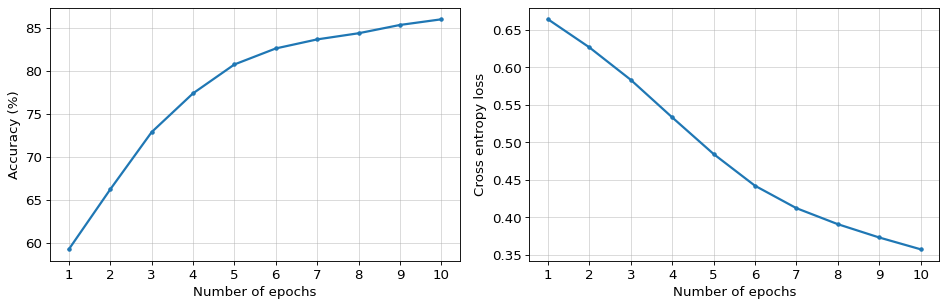

In [39]:
fig_metrics_simple, axes_metrics_simple = plt.subplots(ncols=2, figsize=(12, 4))

axes_metrics_simple[0].plot(epochs, acc_train, '.-')
axes_metrics_simple[0].set_xticks(epochs)
axes_metrics_simple[0].set_xlabel("Number of epochs")
axes_metrics_simple[0].set_ylabel("Accuracy (%)")

axes_metrics_simple[1].plot(epochs, loss_train, '.-')
axes_metrics_simple[1].set_xticks(epochs)
axes_metrics_simple[1].set_xlabel("Number of epochs")
axes_metrics_simple[1].set_ylabel("Cross entropy loss")

plt.tight_layout()

### Evaluate the model during training

It is interesting to see the training procedure and how well the model does on the training data itself. However, with neural networks, it is relatively easy for overfitting to occur. Overfitting is when the model fails to generalize to unseen data.

It would be useful if we could also evaluate the performance on a separate validation set during training to evaluate how well the model generalizes. As it turns out, the [`tf.keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method has an argument just for that: `validation_data`. If using array-like inputs, then it should be a tuple of a corresponding input and target array.

To illustrate this, we will load in the validation set (generated with the `generate_data.py` script) and retrain the model with this new parameter. For the sake of comparison, it is best to load in the same random weights that we used previously. 

In [40]:
X_noisy_val = np.load(Path(datadir, "val", "X_noisy_library.npy"))
X_clean_val = np.load(Path(datadir, "val", "y_clean_library.npy"))
y_nsite_val = np.load(Path(datadir, "val", "y_nsite_library.npy"))

In [41]:
y_val = (y_nsite_val > 1).astype(int)

In [42]:
model_dense_fun.load_weights(dense_weights_file)

In [43]:
history_2 = model_dense_fun.fit(X_noisy, y, epochs=10, verbose=1, validation_data=(X_noisy_val, y_val))

Epoch 1/10
786/786 [==============================] - 2s 2ms/step - loss: 0.6640 - binary_accuracy: 0.5930 - val_loss: 0.6516 - val_binary_accuracy: 0.6398
Epoch 2/10
786/786 [==============================] - 2s 2ms/step - loss: 0.6265 - binary_accuracy: 0.6625 - val_loss: 0.6561 - val_binary_accuracy: 0.5453
Epoch 3/10
786/786 [==============================] - 2s 2ms/step - loss: 0.5833 - binary_accuracy: 0.7290 - val_loss: 0.5862 - val_binary_accuracy: 0.6835
Epoch 4/10
786/786 [==============================] - 2s 2ms/step - loss: 0.5333 - binary_accuracy: 0.7740 - val_loss: 0.5260 - val_binary_accuracy: 0.7587
Epoch 5/10
786/786 [==============================] - 2s 2ms/step - loss: 0.4844 - binary_accuracy: 0.8075 - val_loss: 0.4700 - val_binary_accuracy: 0.8178
Epoch 6/10
786/786 [==============================] - 2s 2ms/step - loss: 0.4421 - binary_accuracy: 0.8261 - val_loss: 0.4300 - val_binary_accuracy: 0.8403
Epoch 7/10
786/786 [==============================] - 2s 2ms/ste

Let's looks at this new [`History`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History) object. The main thing to note is that there are now two more keys in the `history` attribute: the corresponding metrics on evaluated on the validation set (beginning with `val_`).

In [44]:
history_2.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

We can now plot these metrics on the training and validation sets on the same figure to better visualize how well the model is generalizing.

In [45]:
acc_2_train = np.array(history_2.history["binary_accuracy"]) * 100
loss_2_train = np.array(history_2.history["loss"])

acc_2_val = np.array(history_2.history["val_binary_accuracy"]) * 100
loss_2_val = np.array(history_2.history["val_loss"])

epochs_2 = np.arange(1, len(acc_2_train) + 1, 1)

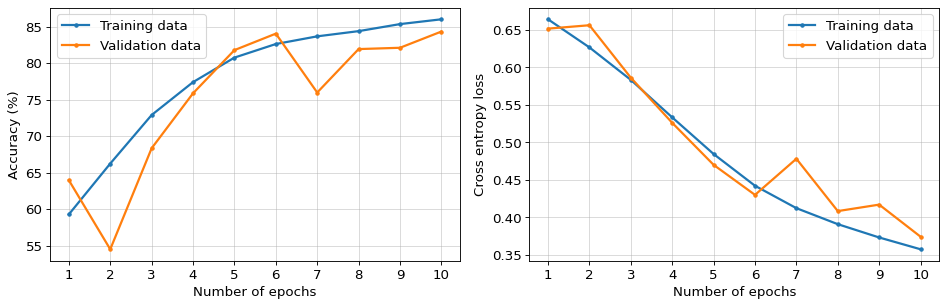

In [46]:
fig_metrics_simple_2, axes_metrics_simple_2 = plt.subplots(ncols=2, figsize=(12, 4))

axes_metrics_simple_2[0].plot(epochs_2, acc_2_train, '.-', label="Training data")
axes_metrics_simple_2[0].plot(epochs_2, acc_2_val, '.-', label="Validation data")
axes_metrics_simple_2[0].set_xticks(epochs)
axes_metrics_simple_2[0].set_xlabel("Number of epochs")
axes_metrics_simple_2[0].set_ylabel("Accuracy (%)")
axes_metrics_simple_2[0].legend()

axes_metrics_simple_2[1].plot(epochs_2, loss_2_train, '.-', label="Training data")
axes_metrics_simple_2[1].plot(epochs_2, loss_2_val, '.-', label="Validation data")
axes_metrics_simple_2[1].set_xticks(epochs)
axes_metrics_simple_2[1].set_xlabel("Number of epochs")
axes_metrics_simple_2[1].set_ylabel("Cross entropy loss")
axes_metrics_simple_2[1].legend()

plt.tight_layout()

Overall, the model is doing fairly well at generalizing! The validation performance, especially the accuracy, isn't as stable as with the training. For some epochs, the loss is significantly higher and the accuracy significantly lower. However, there isn't a massive *average* gap between the two curves.

As well, the best epoch for the validation set is not necessarily the last one (although in this particular instance, it is) due to randomness. With the training set, unless the hyperparameters are poorly tuned, the loss curve will typically flatten out and the best performance on the training set itself will occur near the end. That being said, we don't care too much about the performance on the training set.

### Save the trained model

We have now trained a model which is fairly successful (at a first glance, anyway) without too much effort! At this point, it is helpful to save it for later. One might do this to deploy it on another server, or just to look at it in the future.

There are two ways to do this, and there are also several options to think about when saving. The [`tf.keras.Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model) class has a [`save`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#save) method which accepts, at a minimum, a file path. If the filepath has the extension `.h5`, the model will be saved in the Keras HDF5 format, whereas any other extension (or no extension) will save the model in the `SavedModel` format. The HDF5 format is older, but more lightweight, than the `SavedModel` format. However, it does have some limitations, the biggest of which is that custom objects are not included in the file. Any functions or classes that are defined in Python must be supplied again when loading the model. See [here](https://www.tensorflow.org/guide/keras/save_and_serialize#limitations) for more information on the limitations.

For that reason, we will stick with the `SavedModel` format from now on. Let's define a model path and save the model.

In [47]:
model_dense_fun_path = Path("models/classifiers/simple_dense_nn")

In [48]:
# Create any of the necessary directories or subdirectories for saving.
model_dense_fun_path.parent.mkdir(exist_ok=True, parents=True)

In [49]:
model_dense_fun.save(model_dense_fun_path)

INFO:tensorflow:Assets written to: models/classifiers/simple_dense_nn/assets


Now that the model is saved, take a look at the contents. Notice that it is actually a folder:

```sh
$ ls -1 -p --group-directories-first models/classifiers/simple_dense_nn
assets/
variables/
keras_metadata.pb
saved_model.pb
```

Although not particularly important for this tutorial, `saved_model.pb` contains the network architecture and information specified when compiling the model. The `variable/` folder contains the weights of the network.

For more information on the `SavedModel` format, see [the `SavedModel` format guide](https://www.tensorflow.org/guide/saved_model). Also see [the guide on saving and loading Keras models](https://www.tensorflow.org/guide/keras/save_and_serialize) for a more general overview of saving trained models.

### Add a callback to the training loop

There is another, more automated, way to save the model. To understand this other method, we need to understand callbacks. Callbacks in TensorFlow are used to perform an action at a specific point in the training, evaluation, and/or prediction stages. Actions can be performed at the start or end of training, at the epoch level, or even at the batch level.

All callbacks inherit from the base [`tf.keras.callbacks.Callback`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback) class. Looking at the documentation, there are numerous methods of the form `on_epoch_begin` or `on_epoch_end` that can be overridden to perform some function at the given stage. The [`tf.keras.callbacks`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) module provides a list of some useful callbacks that come with TensorFlow, and the one that we will use is called [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint). As usual, it is easiest to understand with an example. We will start by creating an instance of this callback:

In [50]:
model_dense_fun_checkpoint_path = Path("models/classifiers/simple_dense_nn_best")

In [51]:
# Create any of the necessary directories or subdirectories for saving.
model_dense_fun_checkpoint_path.parent.mkdir(exist_ok=True, parents=True)

In [52]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_dense_fun_checkpoint_path,
                                                      monitor="val_loss",
                                                      save_best_only=True,
                                                      save_freq='epoch',
                                                      mode="min")

The only required argument is the file path to save the model to. Everything else is optional and has a set default. The `monitor` argument is the metric for the callback to watch and base its decision to save the model. The `save_best_only` argument means that the model will only be saved if the metric specified by `monitor` improves. The `save_freq` argument determines with what frequency to check the metric and save the model (in this case, on every epoch). Finally, the `mode` argument specifies whether the metric is supposed to be minimized or maximized. If you were saving the model based on the validation accuracy (which in general is not advisable, although that is a different discussion), you would want to set `mode="max"`.

To actually use this callback, there is a `callback` argument in the [`tf.keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit), [`tf.keras.Model.evaluate`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate), and [`tf.keras.Model.predict`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict) methods. This argument accepts a list of [`tf.keras.callbacks.Callback`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback) objects. Let's retrain the model from its initial weights (again) with this new callback.

In [53]:
model_dense_fun.load_weights(dense_weights_file)

In [54]:
_ = model_dense_fun.fit(X_noisy, y, epochs=10, verbose=1,
                        validation_data=(X_noisy_val, y_val),
                        callbacks=[model_checkpoint])

Epoch 1/10
786/786 [==============================] - 2s 2ms/step - loss: 0.6640 - binary_accuracy: 0.5930 - val_loss: 0.6516 - val_binary_accuracy: 0.6398
INFO:tensorflow:Assets written to: models/classifiers/simple_dense_nn_best/assets
Epoch 2/10
786/786 [==============================] - 2s 2ms/step - loss: 0.6265 - binary_accuracy: 0.6625 - val_loss: 0.6561 - val_binary_accuracy: 0.5453
Epoch 3/10
786/786 [==============================] - 2s 2ms/step - loss: 0.5833 - binary_accuracy: 0.7290 - val_loss: 0.5862 - val_binary_accuracy: 0.6835
INFO:tensorflow:Assets written to: models/classifiers/simple_dense_nn_best/assets
Epoch 4/10
786/786 [==============================] - 2s 2ms/step - loss: 0.5333 - binary_accuracy: 0.7740 - val_loss: 0.5260 - val_binary_accuracy: 0.7587
INFO:tensorflow:Assets written to: models/classifiers/simple_dense_nn_best/assets
Epoch 5/10
786/786 [==============================] - 2s 2ms/step - loss: 0.4844 - binary_accuracy: 0.8075 - val_loss: 0.4700 - va

Since we used a different name for this model, we can see that it did indeed save. As well, looking at the information printed out above, we can even see on which epochs the model was saved based on the `INFO:tensorflow:Assets written to: models/classifiers/simple_dense_nn/assets` log message. As it turns out, the best model (according to the validation loss) is the one at the last epoch.

For more information on callbacks and for some instructions on how to write a custom one, see [the guide on writing your own callbacks](https://www.tensorflow.org/guide/keras/custom_callback#usage_of_logs_dict).

## Train a more complicated model (fully-connected neural network)

## Train a more complicated model (convolutional neural network)